In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchsparse import SparseTensor
import torchsparse.nn as spnn
import scipy


In [10]:
import torchsparse
torchsparse.__version__

'2.1.0+torch20cu117'

In [12]:
def scatter_nd(indices, updates, shape):
    """pytorch edition of tensorflow scatter_nd.
    this function don't contain except handle code. so use this carefully
    when indice repeats, don't support repeat add which is supported
    in tensorflow.
    """
    ret = torch.zeros(*shape, dtype=updates.dtype, device=updates.device)
    ndim = indices.shape[-1]
    output_shape = list(indices.shape[:-1]) + shape[indices.shape[-1]:]
    flatted_indices = indices.view(-1, ndim)
    slices = [flatted_indices[:, i] for i in range(ndim)]
    slices += [Ellipsis]
    ret[slices] = updates.view(*output_shape)
    return ret

def to_dense(sp, bs, shape):
    ndim = len(shape)
    # trans_params = list(range(ndim))
    # trans_params.insert(0, ndim)
    C = sp.feats.size(1)
    # indices = sp.coords[:,trans_params]
    indices = sp.coords
    
    output_shape = [bs, *shape, C]
    res = scatter_nd(
        indices.to(sp.feats.device).long(), sp.feats,
        output_shape)

    trans_params = list(range(0, ndim + 1))
    trans_params.insert(1, ndim + 1)
    res = res.permute(*trans_params).contiguous()
    return res

In [13]:
input_size=[32,32,32]
num_samples=1
sparsity=0.1
seed=2
r = np.random.default_rng(seed=seed)
size = tuple([num_samples] + input_size)
_mask = r.random(size=size) < sparsity
_mask = scipy.ndimage.binary_dilation(_mask[0], iterations=1, structure=np.ones([3]*len(input_size)))[np.newaxis,...]

mask = torch.tensor(_mask).to_sparse().coalesce()
indices = mask.indices().permute(1,0).type(torch.int32)
features = r.random(size=(len(indices),1))
features = np.ones_like(features)
features = torch.tensor(features).float()

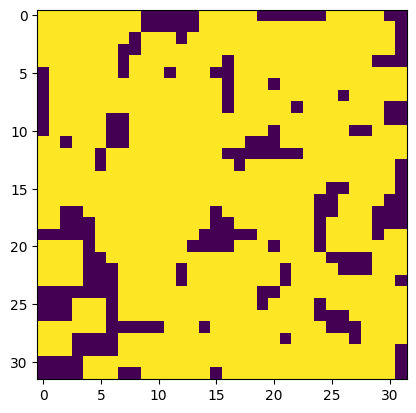

In [22]:
plt.imshow(_mask[0][0])
plt.show()

In [30]:
x = SparseTensor(coords=indices.cuda(), feats=features.cuda())

In [6]:
x.dense()

AssertionError: 

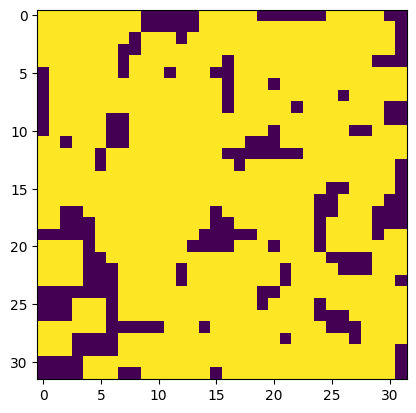

In [24]:
for i in range(1):
    plt.imshow(to_dense(x, 1, input_size)[0,0,i].detach().cpu().numpy())
    # plt.imshow(x.dense()[0,0,i].detach().cpu().numpy())
    plt.show()

In [31]:
conv = spnn.Conv3d(
            in_channels=1,
            out_channels=2,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=False,
        )
nn.init.constant_(conv.kernel, 1.)
conv = conv.cuda()
z = conv(x)
len(z.coords), len(x.coords)

(4096, 30443)

In [28]:

# z.coords[:,:3] //=2
z.coords.max(dim=0)

torch.return_types.max(
values=tensor([ 0, 14, 14, 14], device='cuda:0', dtype=torch.int32),
indices=tensor([   0, 3150,  210,   14], device='cuda:0'))

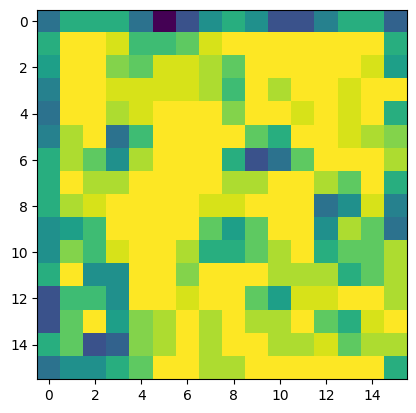

In [27]:
for i in range(1):
    plt.imshow(to_dense(z, 1, [16,16,16])[0,0,i].detach().cpu().numpy())
    plt.show()